# Capstone Project- Time Series Modeling Workbook
Cary Mosley, May 2020

## Import Libraries

In [1]:
import pandas as pd
import calendar, time
import datetime as dt
from datetime import date
from pandas.tseries.offsets import DateOffset
import numpy as np
import string, re 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings("ignore")

## Outline
* First I will check for stationarity/unit roots using the Dickey-Fuller and if I find the time series are not stationary I will work with the data to arrive at stationarity.
* I will construct a baseline persistance model for both SPY and VIX
* I will construct ARIMAX models for both SPY and VIX seperately using senitment indicators and the NY Times sentiment analysis seperately
* I will work with my sentiment indicators to feature engineer and then build another set of ARIMAX models using this data
* I will create a VAR model using SPY and VIX together

# Stationarity

The first thing I'm going to do is check for unit roots on SPY and VIX using a Dickey Fuller test.

In [2]:

def DickeyFullerTest(time_series, alpha = .05):
    '''This function takes in a time series and then outputs and formats the results of
    a Dickey-Fuller test You can also optionally send in a specific p value.
    '''
    #initialize test
    DFTest = adfuller(time_series)
    
    #results
    results = pd.Series(DFTest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    if results[1] > alpha:
        print('We fail to reject the null hypothesis that there is a unit root as our p-value of'
              , round(results[1],3), 'is greater than our alpha of', alpha,'\n')
    else:
        print('Our p-value of', round(results[1],3), 'is less than our alpha of', alpha,
              'so we reject the null hypothesis that there is a unit root. The data is stationary.\n')
    print ('Dickey-Fuller test: \n')
    print(results)

In [3]:
# Read in the SPY and VIX data
spy_df=pd.read_pickle('Data/spy_df')
vix_df=pd.read_pickle('Data/vix_df')

In [4]:
spy_df.head()

,Adj Close,Ticker
Date,,
2006-06-29,96.124527,SPY
2006-07-06,96.086758,SPY
2006-07-13,94.830073,SPY
2006-07-20,93.916246,SPY
2006-07-27,95.820935,SPY


In [5]:
#Dropping the ticker column
spy_df = spy_df['Adj Close'].to_frame()
vix_df = vix_df['Adj Close'].to_frame()

Now I will run the Dickey Fuller tests


In [6]:
spy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 723 entries, 2006-06-29 to 2020-04-30
Freq: W-THU
Data columns (total 1 columns):
Adj Close    723 non-null float64
dtypes: float64(1)
memory usage: 11.3 KB


In [7]:
#Set alpha
alpha = .05
DickeyFullerTest(spy_df['Adj Close'],alpha)

We fail to reject the null hypothesis that there is a unit root as our p-value of 0.974 is greater than our alpha of 0.05 

Dickey-Fuller test: 

Test Statistic                   0.223900
p-value                          0.973571
#Lags Used                       9.000000
Number of Observations Used    713.000000
dtype: float64


In [8]:
DickeyFullerTest(vix_df['Adj Close'],alpha)

Our p-value of 0.031 is less than our alpha of 0.05 so we reject the null hypothesis that there is a unit root. The data is stationary.

Dickey-Fuller test: 

Test Statistic                  -3.042269
p-value                          0.031131
#Lags Used                      11.000000
Number of Observations Used    711.000000
dtype: float64


The SPY data is not stationary while the VIX data already is. I'll first take the log values and then difference the SPY data and then perform the Dickey Fuller test again. Although we rejected the null that the VIX data is not stationary I will also create models that use the logged difference of VIX to see how they perform.

In [121]:

vix_diff=vix_df.diff().dropna()

In [122]:

spy_diff = spy_df.diff().dropna()

In [123]:
DickeyFullerTest(spy_diff['Adj Close'],alpha)

Our p-value of 0.0 is less than our alpha of 0.05 so we reject the null hypothesis that there is a unit root. The data is stationary.

Dickey-Fuller test: 

Test Statistic                -9.722162e+00
p-value                        9.480394e-17
#Lags Used                     8.000000e+00
Number of Observations Used    7.130000e+02
dtype: float64


Text(0.5, 1.0, 'Differenced SPY close over time')

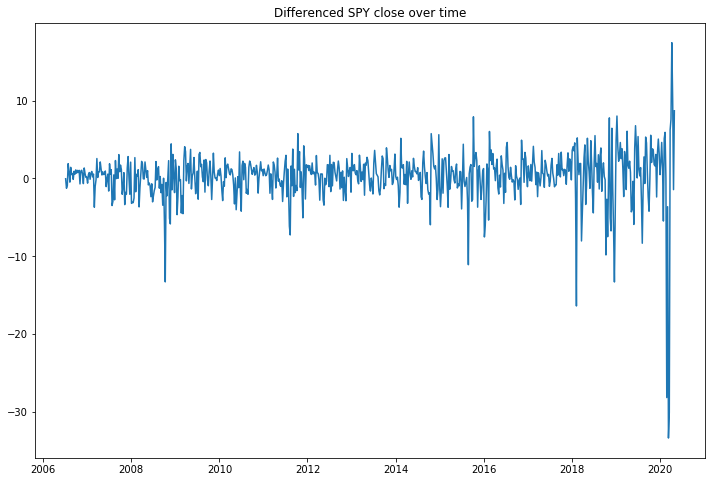

In [124]:
plt.figure(figsize=(12,8))
plt.plot(spy_diff)
plt.title('Differenced SPY close over time')

In [125]:
#Writing the differenced SPY to a pickle
spy_diff.to_pickle('Data/spy_diff')
vix_diff.to_pickle('Data/vix_diff')

Now that we have confirmed both our time series are stationary its time to examine the ACF and PACF plots so that we can build our baseline models.

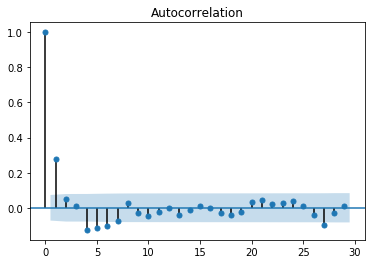

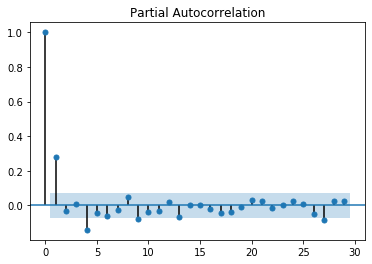

In [126]:
alpha=.05
plot_acf(spy_diff['Adj Close'], alpha=alpha);
plot_pacf(spy_diff['Adj Close'], alpha=alpha);

The autocorrelation plot tells us whether we need to add MA terms. It is clear that the first lag is significant. The PACF plot shows us also that the 1st lag is going to be useful to include as the AR term. For this first model I'll make sure to use a (1,1,1) and will try some other combinations as well. These plots also look typical for a random walk time series.

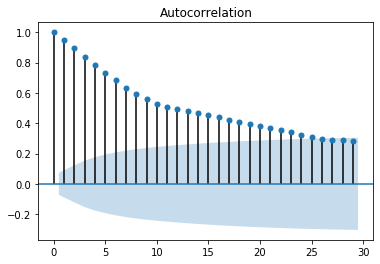

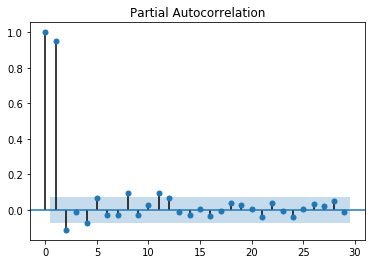

In [127]:
alpha=.05
plot_acf(vix_df['Adj Close'], alpha=alpha);
plot_pacf(vix_df['Adj Close'], alpha=alpha);

We can see from the ACF plot that there are a number of strongly positively correlated lags we can use for the moving average model. This is somewhat expected as there is a tendency for VIX to be sticky for a period of time although it does tend to mean revert to a white noise series. The PACF shows us that only the first lag is strongly correlated. Thus a (1,0,n) model is likely to be decent with n potentially being a number of variables.



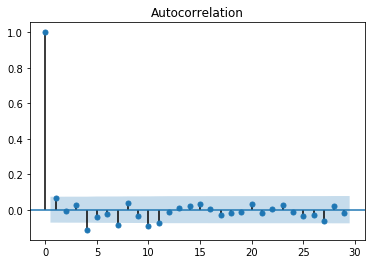

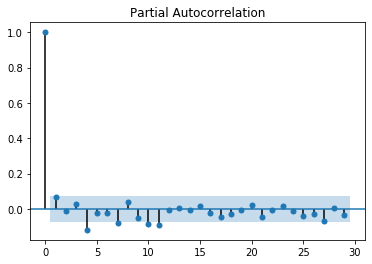

In [128]:
alpha=.05
plot_acf(vix_diff, alpha=alpha);
plot_pacf(vix_diff, alpha=alpha);

It appears that the differenced VIX has no relationship between any past observations. This is what we would expect for a random time series. Now that we have looked through these I will build a baseline model before moving on to more complete models.

# Baseline Models
For my baseline SPY and VIX models I will be using a persistance algorithm where the predicted value at the t+1 time step is the value at the t-1 time step.

In [16]:
spy_baseline = pd.concat([spy_df['Adj Close'].shift(1),spy_df['Adj Close']],axis=1)
spy_baseline.columns = ['t-1', 't+1']

time_series_train = spy_baseline[:'2017-12'].values
time_series_test = spy_baseline['2018-01':].values
time_series_train_X, time_series_train_y = time_series_train[:,0], time_series_train[:,1] 
time_series_test_X, time_series_test_y = time_series_test[:,0], time_series_test[:,1] 

In [17]:
forecasts=[]
for x in time_series_test_X:
    forecast = x
    forecasts.append(forecast)
test_rmse = np.sqrt(mean_squared_error(time_series_test_y,forecasts))
print('The baseline SPY model RMSE is', round(test_rmse,3))

The baseline SPY model RMSE is 6.694


In [18]:
vix_baseline = pd.concat([vix_df['Adj Close'].shift(1),vix_df['Adj Close']],axis=1)
vix_baseline.columns = ['t-1', 't+1']

time_series_train = vix_baseline[:'2017-12'].values
time_series_test = vix_baseline['2018-01':].values
time_series_train_X, time_series_train_y = time_series_train[:,0], time_series_train[:,1] 
time_series_test_X, time_series_test_y = time_series_test[:,0], time_series_test[:,1]

In [19]:
forecasts=[]
for x in time_series_test_X:
    forecast = x
    forecasts.append(forecast)
test_rmse = np.sqrt(mean_squared_error(time_series_test_y,forecasts))
print('The baseline VIX model RMSE is', round(test_rmse,3))

The baseline VIX model RMSE is 4.338


Now that I have constructed the baseline models I will move on to ARIMA and ARIMAX modeling.



# ARIMA and ARIMAX Models
This next section will begin with building and evaluating ARIMA models for SPY and VIX before expanding to include the exogenous variables.

In [70]:
def ARIMA_models(time_series,AR_terms, MA_terms):
    '''This function takes in a timeseries and a set of AR and MA terms to try. The time series
    that it takes in needs to be already stationary. The function then returns a data frame
    of the model results'''
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_series_train = time_series[:'2017-12']
    time_series_test = time_series['2018-01':]
    
    #Create results dataframe
    results = pd.DataFrame(columns=['Order', 'AIC', 'BIC', 'Test RMSE'])
    
    #ignore orders that do not converge or cause other erros
    for p in AR_terms:
        for q in MA_terms:
            try:
                order = (p,0,q)
                
            #create the ARIMA model and forecast
                time_series_model = ARIMA(time_series_train,order=order)
                time_series_fitted = time_series_model.fit()
                
                forecast, error, confidence_interval = time_series_fitted.forecast(len(time_series_test),alpha=.05)
                test_rmse = np.sqrt(mean_squared_error(time_series_test.values,forecast))
                results = results.append({'Order': order, 'AIC' : round(time_series_fitted.aic,3),
                           'BIC': round(time_series_fitted.bic,3),'Test RMSE': round(test_rmse,3)},ignore_index=True)
            except:
                print('Order',order,'caused an error.')
                continue
    return results
    

In [130]:
AR_terms = [1,2]
MA_terms = [1,2]


ARIMA_models(spy_diff['Adj Close'],AR_terms,MA_terms)

,Order,AIC,BIC,Test RMSE
0,"(1, 0, 1)",2598.656,2616.244,6.690
1,"(1, 0, 2)",2600.653,2622.637,6.690
2,"(2, 0, 1)",2600.643,2622.628,6.690
3,"(2, 0, 2)",2602.645,2629.027,6.689


These models look almost identical so we will choose the model we expected from our ACF and PACF plots of (1,1,1). Although they are not much better than the baseline there is a slight improvement.

In [131]:
AR_terms = [1]
MA_terms = [1,2,3,4,5]
ARIMA_models(vix_df,AR_terms,MA_terms)

,Order,AIC,BIC,Test RMSE
0,"(1, 0, 1)",2830.392,2847.986,10.099
1,"(1, 0, 2)",2832.303,2854.296,10.097
2,"(1, 0, 3)",2832.087,2858.479,10.092
3,"(1, 0, 4)",2833.807,2864.597,10.093
4,"(1, 0, 5)",2835.561,2870.750,10.092


For the VIX data we can see that the (1,0,1) model performs the best although soe of the higher order lags also perform very similarly. Now I will check a differenced VIX series as the baseline differenced performs better than the non differenced.

In [132]:
AR_terms = [1]
MA_terms = [1,2]
ARIMA_models(vix_diff,AR_terms,MA_terms)

Order (1, 0, 2) caused an error.


,Order,AIC,BIC,Test RMSE
0,"(1, 0, 1)",2824.894,2842.482,4.337


This is barely better than the baseline.

In [164]:
def plot_model_differenced(time_series, AR = 0, MA = 0):
    """
    This function will graph the time series including the forecast data.
    """
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_series_train = time_series[:'2017-12']
    time_series_test = time_series['2018-01':]
    order = (AR,0,MA)
         
    #create model and forecasts
    time_series_model = ARIMA(endog = time_series_train, order=order)
    time_series_fit = time_series_model.fit()
               
    forecast, error, confidence_interval = time_series_fit.forecast(len(time_series_test), alpha=0.05)
    # Make as pandas series
    forecast_time_series = pd.Series(forecast, index=time_series_test.index)
    lower_bound = pd.Series(confidence_interval[:, 0], index=time_series_test.index)
    upper_bound = pd.Series(confidence_interval[:, 1], index=time_series_test.index)
   
    # Plot the data and forecast
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(time_series_train, label='Train Data')
    plt.plot(time_series_test, label='Actual Values')
    plt.plot(forecast_time_series, label='Forecasted Values')
    plt.fill_between(time_series_test.index, lower_bound, upper_bound, 
                 color='k', alpha=.25)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.savefig("best_model_graph")
    plt.show()
    
def model_summary(time_series,AR=0,MA =0):
    """
    This function will return the summary of the model.
    """
    time_series_train = time_series[:'2017-12']
    time_series_test = time_series['2018-01':]
    order = (AR,0,MA)
    print(ARIMA(time_series_train, order=order).fit().summary())
    
def plot_model_forecasts(time_series_diff,time_series, AR = 0, MA = 0):
    """
    This function will graph the time series including the forecast data.
    """
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_series_train = time_series_diff[:'2017-12']
    time_series_test = time_series_diff['2018-01':]
    values_train = time_series[:'2017-12']
    values_test = time_series['2018-01':]
    order = (AR,0,MA)
         
    #create model and forecasts
    time_series_model = ARIMA(endog = time_series_train, order=order)
    time_series_fit = time_series_model.fit()
    
               
    forecast, error, confidence_interval = time_series_fit.forecast(len(time_series_test), alpha=0.5)
    # Make as pandas series
    # Return to original scale
    forecast_time_series = pd.Series(forecast.cumsum(), index=time_series_test.index)
    forecast_time_series=forecast_time_series+values_train.iloc[-1].values
    
    # Plot the data and forecast
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(values_train, label='Train Data')
    plt.plot(values_test, label='Actual Values')
    plt.plot(forecast_time_series, label='Forecasted Values')
 
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.savefig("best_model_graph")
    plt.show()


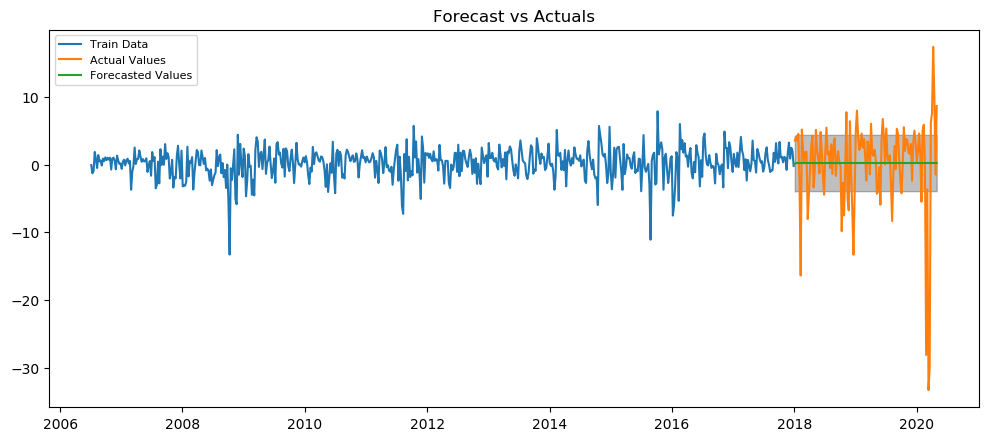

In [160]:
#Show the spy forecasts
plot_model_differenced(spy_diff,1,1)

We can see that the model is predicting essential zero change day on day which is what we would tend to expect for a random walk time series. Lets look at the summary to confirm this.

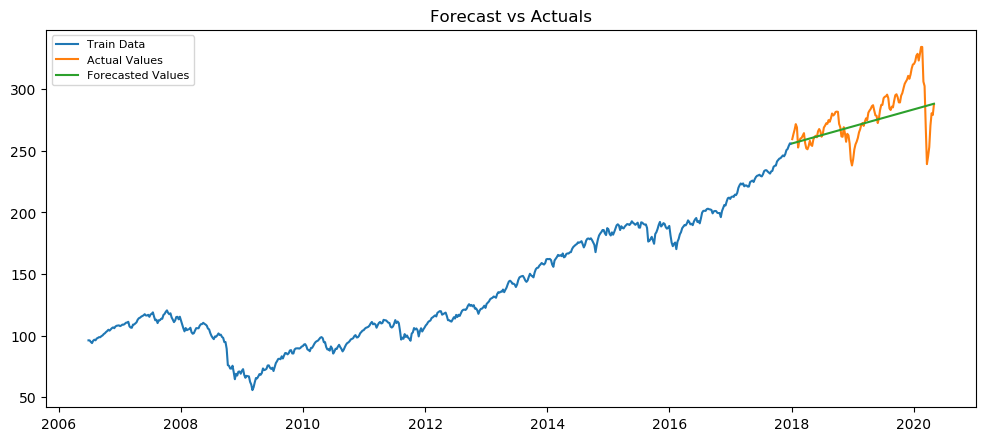

In [165]:
plot_model_forecasts(spy_diff,spy_df,1,1)

When we look at the cumulative forecasts we do see an upwards trend which is what we expect as the SP500 exhibited a longterm positive trend over our time period with random noise for any given day.

In [25]:
model_summary(spy_diff,1,1)

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  600
Model:                     ARMA(1, 1)   Log Likelihood               -1295.328
Method:                       css-mle   S.D. of innovations              2.096
Date:                Tue, 19 May 2020   AIC                           2598.656
Time:                        09:48:55   BIC                           2616.244
Sample:                    07-06-2006   HQIC                          2605.502
                         - 12-28-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2662      0.099      2.691      0.007       0.072       0.460
ar.L1.Adj Close    -0.0387      0.232     -0.167      0.868      -0.493       0.416
ma.L1.Adj Close     0.2012      

Looking at the model summary we can see that the AR term is very close to 0. Essentially we are going to predict very little change in the next days value. Again, this is what we would expect from a random walk, unfortunately it doesnt make our preidcitons very useful. Finally, I'll look at a plot of the first lagged value to the original differenced for a last confirmation.

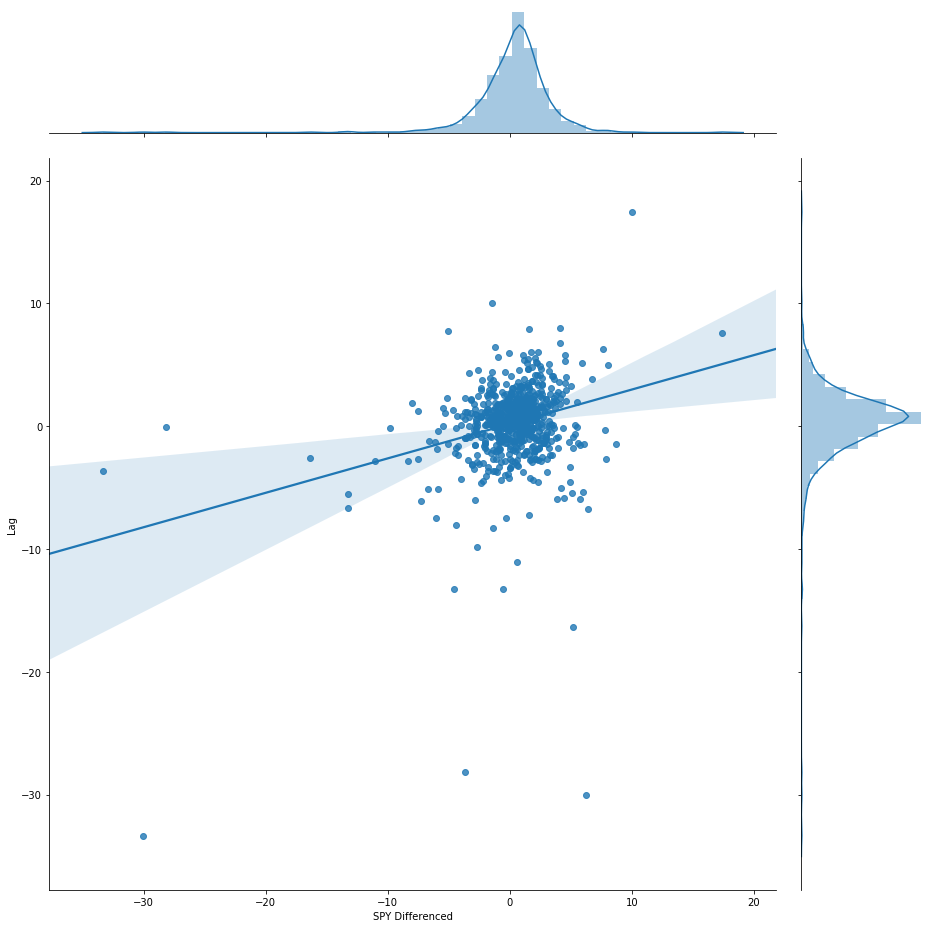

In [26]:
spy_diff.rename(columns={'Adj Close': 'SPY Differenced'},inplace=True)
spy_diff_lag = spy_diff
spy_diff_lag['Lag'] = spy_diff_lag['SPY Differenced'].shift()
sns.jointplot('SPY Differenced', 'Lag', spy_diff_lag, kind='reg', size=13)

The vast majority of the scatterplot is packed relatively evenly around 0,0. This implies that knowing the change the day before is essentially uncorrelated with the next change. This is what we woudl expect from a random walk time series. Due to this low level of impact the model is unable to predict much from the previous times values.

Now lets repeat this for VIX. We would expect a slightly different result as the future value is heavily impacted by the previous one despite the overal series being stationary.

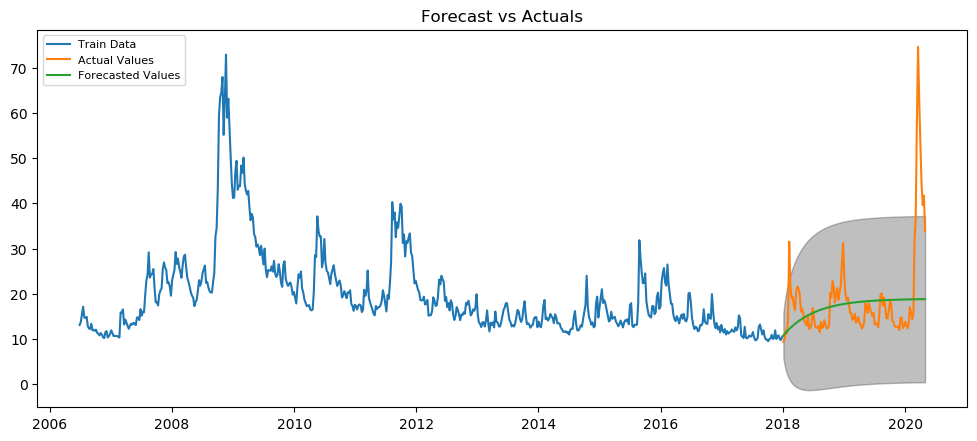

In [27]:
plot_model(vix_df,1,1)

In [28]:
model_summary(vix_df,1,1)

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  601
Model:                     ARMA(1, 1)   Log Likelihood               -1411.196
Method:                       css-mle   S.D. of innovations              2.527
Date:                Tue, 19 May 2020   AIC                           2830.392
Time:                        09:48:56   BIC                           2847.986
Sample:                    06-29-2006   HQIC                          2837.240
                         - 12-28-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              18.8849      2.684      7.037      0.000      13.625      24.145
ar.L1.Adj Close     0.9631      0.011     86.734      0.000       0.941       0.985
ma.L1.Adj Close     0.0002      

We can see that the moving average coefficient is essentially zero but the autoregressive term has quite a significant impact. This is what we would expect in that the current value in VIX is highly dependent on the previous value.

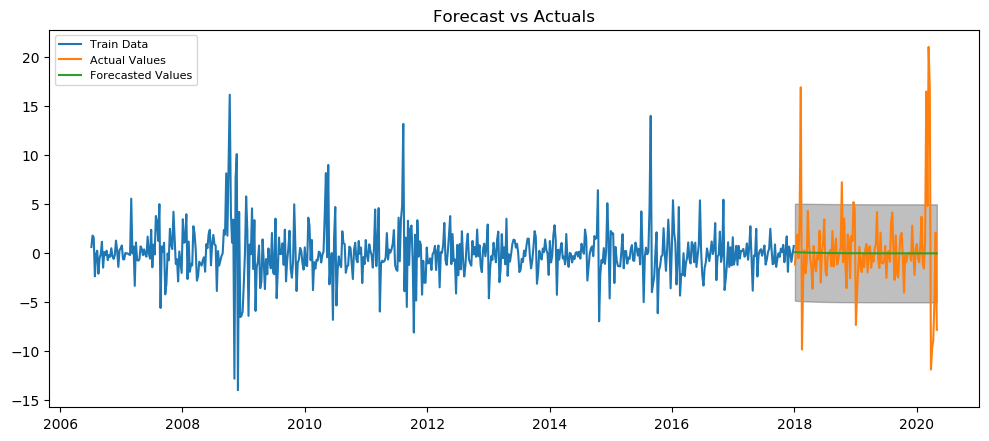

In [162]:
plot_model_differenced(vix_diff,1,1)

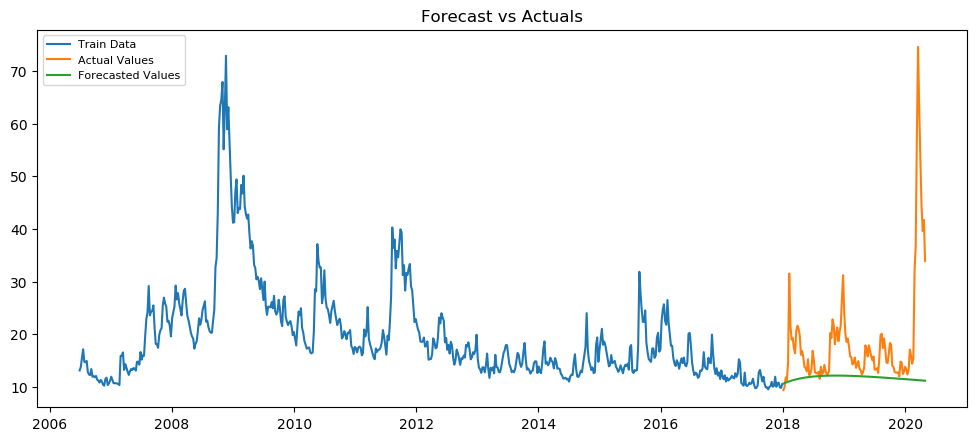

In [166]:
plot_model_forecasts(vix_diff,vix_df,1,1)

The VIX forecasts are roughly stable around the long term mean. This model is not very good at capturing any shocks.

Now I'll move on to adding the sentiment indicators as exogenous variables!

## Adding Sentiment Indicators as an Exogenous variable

Time to add some exogenous variables!

In [29]:
nyt_df = pd.read_pickle('Data/nyt_w_df')
sentiment_df = pd.read_pickle('Data/sentiment_df')

We'll print the first few rows of each dataframe to refresh our memory

In [30]:
nyt_df.head()

,Headline_Blob,Snippet_Blob,Headline_VADER,Snippet_VADER
Date,,,,
2006-06-29,0.026190,0.007771,-0.062524,0.076390
2006-07-06,0.016675,0.043256,-0.018492,0.116522
2006-07-13,-0.005360,0.058999,0.004790,0.121917
2006-07-20,0.009374,0.039992,-0.020284,0.192571
2006-07-27,0.053712,0.045786,0.105633,0.106810


In [31]:
sentiment_df.head()

,Bullish,Neutral,Bearish,Spread,Mean,MaxBear,Median,MaxBull
Date,,,,,,,,
2006-06-29,0.3860,0.2164,0.3977,-0.0117,56.33,-125.0,65.0,125.0
2006-07-06,0.3770,0.1967,0.4262,-0.0492,19.44,-100.0,20.0,100.0
2006-07-13,0.3650,0.2409,0.3942,-0.0292,31.20,-50.0,25.0,150.0
2006-07-20,0.2385,0.1835,0.5780,-0.3395,18.76,-100.0,25.0,100.0
2006-07-27,0.3488,0.2209,0.4302,-0.0814,17.38,-50.0,15.0,100.0


First I will adjust my ARIMA_models function to include an exogenous variable.

In [32]:
def ARIMAX_models_single(time_series,AR_terms, MA_terms,exogenous):
    '''This function takes in a timeseries and a set of AR and MA terms to try. The time series
    that it takes in needs to be already stationary. The function then returns a data frame
    of the model results'''
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_series_train = time_series[:'2017-12']
    time_series_test = time_series['2018-01':]
    exog_train = exogenous[:'2017-12']
    exog_test = exogenous['2018-01':]
    
    #Create results dataframe
    results = pd.DataFrame(columns=['Order', 'AIC', 'BIC', 'Test RMSE', 'Exogenous'])
    
    #ignore orders that do not converge or cause other erros
    for p in AR_terms:
        for q in MA_terms:
            for column in exogenous:
                try:
                    order = (p,0,q)
                
                    #create the ARIMA model and forecast
                    time_series_model = ARIMA(endog = time_series_train, exog = exog_train[[column]], order = order)
                    time_series_fitted = time_series_model.fit()
                    forecast, error, confidence_interval = time_series_fitted.forecast(len(time_series_test),exog=exog_test[[column]], alpha=.05)
                    test_rmse = np.sqrt(mean_squared_error(time_series_test.values,forecast))
                    results = results.append({'Order': order, 'AIC' : round(time_series_fitted.aic,3),
                           'BIC': round(time_series_fitted.bic,3),'Test RMSE': round(test_rmse,3),
                                             'Exogenous': column},ignore_index=True)
                except:
                    print('Order',order,'caused an error.')
                    continue
           
    return results

In order to align everything I will first shift the NY Times and Sentiment Indicator Data

In [33]:
nyt_shifted=nyt_df.shift()
nyt_shifted.dropna(inplace=True)
sentiment_shifted=sentiment_df.shift()
sentiment_shifted.dropna(inplace=True)
exogenous_shifted = pd.concat([sentiment_shifted,nyt_shifted],axis=1,join='inner')

In [42]:
AR_terms = [1]
MA_terms = [1]

ARIMAX_models_single(spy_diff['SPY Differenced'],AR_terms,MA_terms,exogenous=exogenous_shifted)

,Order,AIC,BIC,Test RMSE,Exogenous
0,"(1, 0, 1)",2600.170,2622.154,6.683,Bullish
1,"(1, 0, 1)",2600.417,2622.402,6.688,Neutral
2,"(1, 0, 1)",2600.632,2622.616,6.689,Bearish
3,"(1, 0, 1)",2600.415,2622.399,6.686,Spread
4,"(1, 0, 1)",2600.649,2622.634,6.689,Mean
5,"(1, 0, 1)",2600.537,2622.521,6.694,MaxBear
6,"(1, 0, 1)",2600.563,2622.548,6.690,Median
7,"(1, 0, 1)",2599.761,2621.745,6.692,MaxBull
8,"(1, 0, 1)",2597.852,2619.836,6.722,Headline_Blob
9,"(1, 0, 1)",2600.444,2622.428,6.687,Snippet_Blob


Looking at this the sentiment indicator that provided the most improvement was using the NY Times provided snippet and the VADER sentiment analysis. Later on I'll perform some feature engineering to see if I can improve this. 

In [35]:
AR_terms = [1]
MA_terms = [1]
exogenous_df = pd.concat([sentiment_df,nyt_df],axis=1,join='inner')
ARIMAX_models_single(vix_df,AR_terms,MA_terms,exogenous=exogenous_df)

,Order,AIC,BIC,Test RMSE,Exogenous
0,"(1, 0, 1)",2781.571,2803.564,9.936,Bullish
1,"(1, 0, 1)",2820.699,2842.692,9.817,Neutral
2,"(1, 0, 1)",2747.479,2769.472,9.386,Bearish
3,"(1, 0, 1)",2756.453,2778.446,9.625,Spread
4,"(1, 0, 1)",2794.530,2816.522,9.377,Mean
5,"(1, 0, 1)",2831.198,2853.191,10.067,MaxBear
6,"(1, 0, 1)",2777.869,2799.862,9.107,Median
7,"(1, 0, 1)",2832.378,2854.371,10.104,MaxBull
8,"(1, 0, 1)",2831.688,2853.681,10.072,Headline_Blob
9,"(1, 0, 1)",2831.620,2853.613,10.089,Snippet_Blob


For VIX it looks like the median active manager leverage improved our VIX results significantly.

In [180]:
def plot_model_exog_differenced(time_series, AR, MA, exogenous):
    """
    This function will graph the time series including the forecast data.
    """
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_series_train = time_series[:'2017-12']
    time_series_test = time_series['2018-01':]
    exog_train = exogenous[:'2017-12']
    exog_test = exogenous['2018-01':]
    order = (AR,0,MA)
         
    #create model and forecasts
    time_series_model = ARIMA(endog = time_series_train, exog=exog_train, order=order)
    time_series_fit = time_series_model.fit()
               
    forecast, error, confidence_interval = time_series_fit.forecast(len(time_series_test),exog=exog_test, alpha=0.05)
    # Make as pandas series
    forecast_time_series = pd.Series(forecast, index=time_series_test.index)
    lower_bound = pd.Series(confidence_interval[:, 0], index=time_series_test.index)
    upper_bound = pd.Series(confidence_interval[:, 1], index=time_series_test.index)
   
    # Plot the data and forecast
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(time_series_train, label='Train Data')
    plt.plot(time_series_test, label='Actual Values')
    plt.plot(forecast_time_series, label='Forecasted Values')
    plt.fill_between(time_series_test.index, lower_bound, upper_bound, 
                 color='k', alpha=.25)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.savefig("best_model_graph")
    plt.show()
    
def model_summary_exog(time_series,AR,MA,exogenous):
    """
    This function will return the summary of the model.
    """
    time_series_train = time_series[:'2017-12']
    time_series_test = time_series['2018-01':]
    
    exog_train = exogenous[:'2017-12']
    exog_test = exogenous['2018-01':]
    
    order = (AR,0,MA)
    print(ARIMA(time_series_train,exog=exog_train, order=order).fit().summary())
    
def plot_model_exog_forecasts(time_series_diff,time_series, AR, MA, exogenous):
    """
    This function will graph the time series including the forecast data.
    """
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_series_train = time_series_diff[:'2017-12']
    time_series_test = time_series_diff['2018-01':]
    exog_train = exogenous[:'2017-12']
    exog_test = exogenous['2018-01':]
    values_train = time_series[:'2017-12']
    values_test = time_series['2018-01':]
    order = (AR,0,MA)
         
    #create model and forecasts
    time_series_model = ARIMA(endog = time_series_train, exog=exog_train, order=order)
    time_series_fit = time_series_model.fit()
               
    forecast, error, confidence_interval = time_series_fit.forecast(len(time_series_test),exog=exog_test, alpha=0.5)
    # Make as pandas series
    # Return to original scale
    forecast_time_series = pd.Series(forecast.cumsum(), index=time_series_test.index)
    forecast_time_series=forecast_time_series+values_train.iloc[-1].values
   
    # Plot the data and forecast
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(values_train, label='Train Data')
    plt.plot(values_test, label='Actual Values')
    plt.plot(forecast_time_series, label='Forecasted Values')
    
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.savefig("best_model_graph")
    plt.show()    
    
   

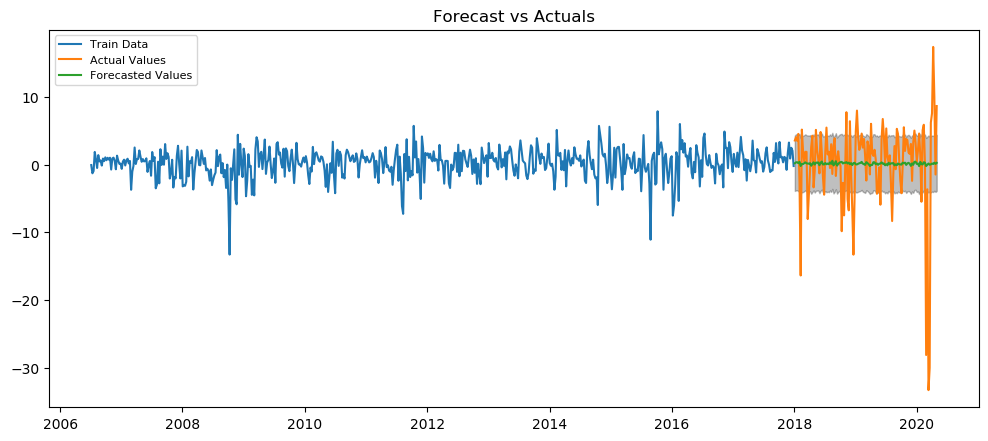

In [170]:
exog=exogenous_shifted[['Snippet_VADER']]
plot_model_exog_differenced(spy_diff['Adj Close'],1,1,exog)

Its clear from the graph that the model's estimates are incorporating the sentiment data but the predicted moves are still significantly smaller than the actual ones.

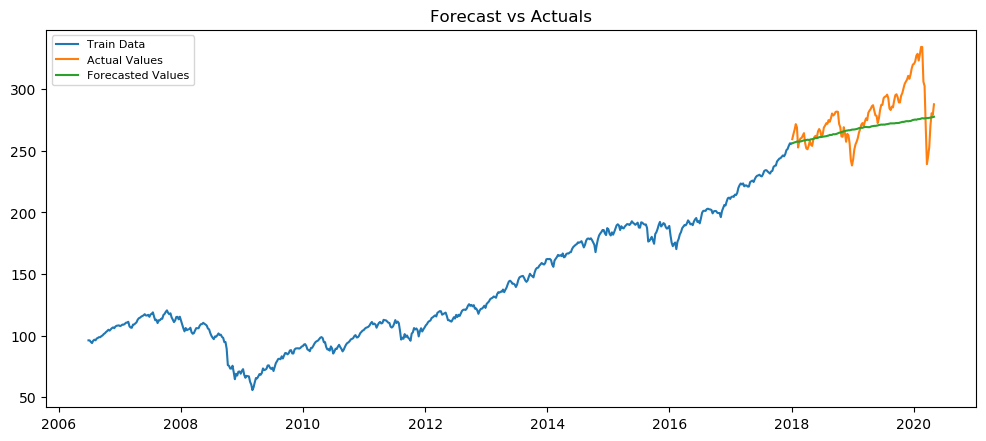

In [181]:
plot_model_exog_forecasts(spy_diff['Adj Close'],spy_df,1,1,exog)

In [44]:
model_summary_exog(spy_diff['SPY Differenced'],1,1,exog)

                              ARMA Model Results                              
Dep. Variable:        SPY Differenced   No. Observations:                  600
Model:                     ARMA(1, 1)   Log Likelihood               -1294.680
Method:                       css-mle   S.D. of innovations              2.094
Date:                Tue, 19 May 2020   AIC                           2599.359
Time:                        09:53:16   BIC                           2621.344
Sample:                    07-06-2006   HQIC                          2607.917
                         - 12-28-2017                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1366      0.150      0.910      0.363      -0.158       0.431
Snippet_VADER             1.5068      1.324      1.139      0.255      -1.087       4.101
ar.L1.SP

Although it provided a small amount of improvement, its clear from the model summary that we could not definitely say that the coefficient for the VADER sentiment is not 0. 

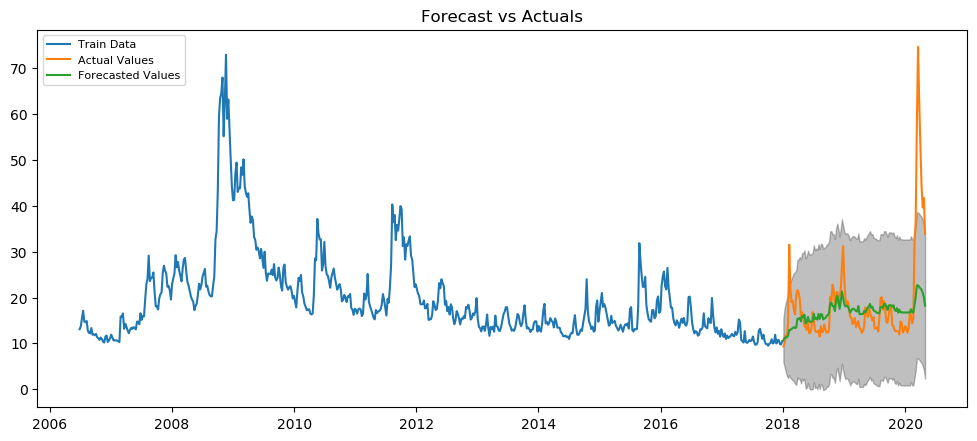

In [45]:
exog=exogenous_df[['Median']]
plot_model_exog(vix_df,1,1,exog)

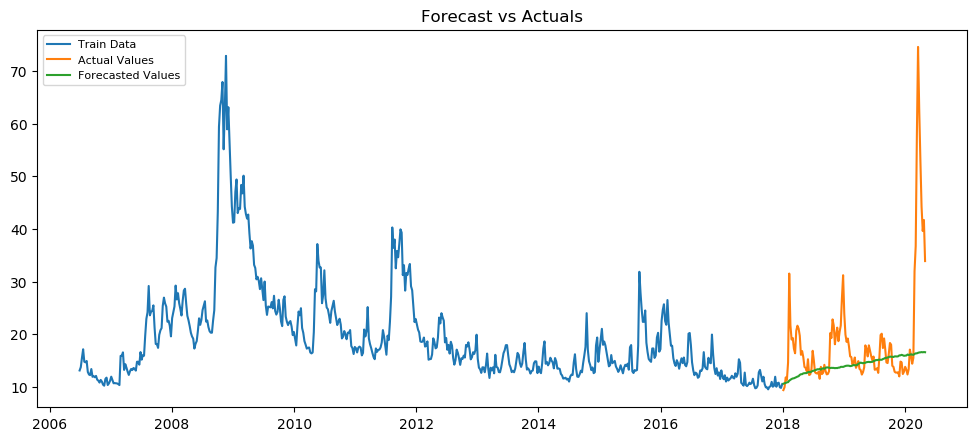

In [182]:
plot_model_exog_forecasts(vix_diff['Adj Close'],vix_df,1,1,exog)

The forecast model looks like an improvement over the baseline and the ARIMA model! Looking at the summary below we would reject that the coefficient is 0. When there is a higher median leverage we would expect a lower value of VIX. This makes sense as VIX is known as the "fear" index.

In [46]:
model_summary_exog(vix_df,1,1,exog)

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  601
Model:                     ARMA(1, 1)   Log Likelihood               -1383.935
Method:                       css-mle   S.D. of innovations              2.415
Date:                Tue, 19 May 2020   AIC                           2777.869
Time:                        09:53:25   BIC                           2799.862
Sample:                    06-29-2006   HQIC                          2786.430
                         - 12-28-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              23.3710      2.344      9.969      0.000      18.776      27.966
Median             -0.0654      0.009     -7.428      0.000      -0.083      -0.048
ar.L1.Adj Close     0.9614      

# Feature Engineering
In this section I'll play around with my exogenous variables to see if I can improve my results

# VAR Model
In this section I'll building a combined model using VIX, SPY and by best performing exogenous features

In [ ]:
def VAR_models_single(time_series,AR_terms, MA_terms,exogenous):
    '''This function takes in a timeseries and a set of AR and MA terms to try. The time series
    that it takes in needs to be already stationary. The function then returns a data frame
    of the model results'''
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_series_train = time_series[:'2017-12']
    time_series_test = time_series['2018-01':]
    exog_train = exogenous[:'2017-12']
    exog_test = exogenous['2018-01':]
    
    #Create results dataframe
    results = pd.DataFrame(columns=['Order', 'AIC', 'BIC', 'Test RMSE', 'Exogenous'])
    
    #ignore orders that do not converge or cause other erros
    for column in exogenous:
      
    #create the VAR model and forecast
        time_series_model = VAR(endog = time_series_train, exog = exog_train[[column]])
        time_series_fitted = time_series_model.fit()
        
        forecasts = time_series_fitted.forecast(y= time_series_fitted.y, steps = len(time_series_test),exog_future=exog_test[[column]])
        forecast_df = pd.DataFrame(index=range(0,len(forecasts)),columns=time_series.columns)
        
        for j in range(0,len(time_series.columns)):
            for i in range(0,len(forecasts)):
                forecast_df.iloc[i][j]=forecasts[i][j]
        
        
        test_rmse = np.sqrt(mean_squared_error(time_series_test.values,forecast))
        results = results.append({'Order': order, 'AIC' : round(time_series_fitted.aic,3),
                           'BIC': round(time_series_fitted.bic,3),'Test RMSE': round(test_rmse,3),
                                             'Exogenous': column},ignore_index=True)
           
    return results

The first thing I'm going to do is merge the VIX and SPY dataframes.

In [ ]:
var_df = pd.concat([spy_diff,vix_df],axis=1,join='inner')
var_df

In [ ]:
AR_terms = [1]
MA_terms = [1]
VAR_models_single(var_df,AR_terms,MA_terms,exogenous=exogenous_shifted)

In [ ]:
time_series_train = var_df[:'2017-12']
time_series_test = var_df['2018-01':]
exog_train = exogenous_shifted[:'2017-12']
exog_test = exogenous_shifted['2018-01':]


In [ ]:
time_series_model = VAR(endog = time_series_train, exog = exog_train[['Median']])
time_series_fitted = time_series_model.fit()

In [ ]:
forecasts = time_series_fitted.forecast(y= time_series_fitted.y, steps=len(time_series_test),exog_future=exog_test[['Median']])




In [ ]:
forecast